You will build end-to-end pipelines in future courses but for this one, you will only build up to the feature engineering part. Specifically, you will:

* ingest data from a base directory with `ExampleGen`
* compute the statistics of the training data with `StatisticsGen`
* infer a schema with `SchemaGen`
* detect anomalies in the evaluation data with `ExampleValidator`
* preprocess the data into features suitable for model training with `Transform`



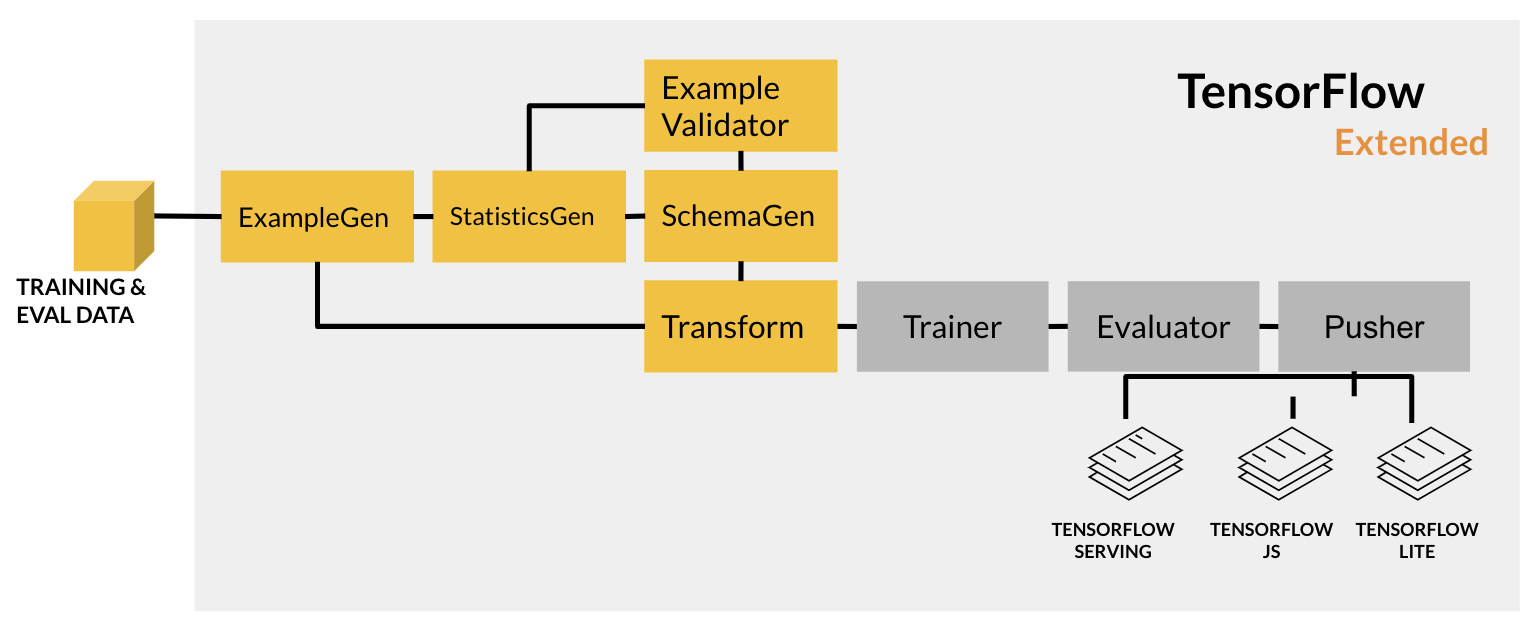

# Import packages

In [ ]:
%%capture
!pip install tfx

In [ ]:
import tensorflow as tf

from tfx.components import CsvExampleGen
from tfx.components import ExampleValidator
from tfx.components import SchemaGen 
from tfx.components import StatisticsGen 
from tfx.components import Transform 

from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from google.protobuf.json_format import MessageToDict 

import os 
import pprint 
pp = pprint.PrettyPrinter()

# Define paths

In [92]:
# location of the pipeline metadata store
_pipeline_root = '/content/pipeline'

# directory of the raw data files
_data_root = '/content/drive/MyDrive/MLOPS/tft/data/adult/'

# path to the raw training data
_data_filepath = os.path.join(_data_root, 'adult.data')

# Preview the  dataset

You will again be using the [Census Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult) from the Week 1 ungraded lab so you can compare outputs when just using stand-alone TFDV and when using it under TFX. Just to remind, the data can be used to predict if an individual earns more than or less than 50k US Dollars annually. Here is the description of the features again: 


* **age**: continuous.
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* **fnlwgt**: continuous.
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* **education-num**: continuous.
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* **sex**: Female, Male.
* **capital-gain**: continuous.
* **capital-loss**: continuous.
* **hours-per-week**: continuous.
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [93]:
# preview the first few rows of the csv file
!head {_data_filepath}

age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0,

# Create the Interactive Context

When pushing to production, you want to automate the pipeline execution using orchestrators such as [Apache Beam](https://beam.apache.org/) and [Kubeflow](https://www.kubeflow.org/). You will not be doing that just yet and will instead execute the pipeline from this notebook. When experimenting in a notebook environment, you will be *manually* executing the pipeline components (i.e. you are the orchestrator). For that, TFX provides the [Interactive Context](https://github.com/tensorflow/tfx/blob/master/tfx/orchestration/experimental/interactive/interactive_context.py) so you can step through each component and inspect its outputs.

You will initialize the `InteractiveContext` below. This will create a database in the `_pipeline_root` directory which the different components will use to save or get the state of the component executions. You will learn more about this in Week 3 when we discuss ML Metadata. For now, you can think of it as the data store that makes it possible for the different pipeline components to work together. 

*Note: You can configure the database to connect to but for this exercise, we will just use the default which is a newly created local sqlite file.* ***You will see the warning after running the cell below and you can safely ignore it.***

In [94]:
# Initialize the InteractiveContext with a local sqlite file.
# If you leave `_pipeline_root` blank, then the db will be created in a temporary directory.
# You can safely ignore the warning about the missing config file.
context = InteractiveContext(pipeline_root=_pipeline_root)

# Run TFX components interactively

With that, you can now run the pipeline interactively. You will see how to do that as you go through the different components below.

## ExampleGen

You will start the pipeline with the [ExampleGen](https://www.tensorflow.org/tfx/guide/examplegen) component. This  will:

*   split the data into training and evaluation sets (by default: 2/3 train, 1/3 eval).
*   convert each data row into `tf.train.Example` format. This [protocol buffer](https://developers.google.com/protocol-buffers) is designed for Tensorflow operations and is used by the TFX components.
*   compress and save the data collection under the `_pipeline_root` directory for other components to access. These examples are stored in `TFRecord` format. This optimizes read and write operations within Tensorflow especially if you have a large collection of data.

Its constructor takes the path to your data source/directory. In our case, this is the `_data_root` path. The component supports several data sources such as CSV, tf.Record, and BigQuery. Since our data is a CSV file, we will use [CsvExampleGen](https://www.tensorflow.org/tfx/api_docs/python/tfx/components/CsvExampleGen) to ingest the data.

Run the cell below to instantiate `CsvExampleGen`.

In [95]:
# Instantiate ExampleGen with the input CSV dataset
example_gen = CsvExampleGen(input_base=_data_root)

You can execute the component by calling the `run()` method of the `InteractiveContext`.

In [96]:
# Execute the component
context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 9
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 37
        type_id: 14
        uri: "/content/pipeline/CsvExampleGen/examples/9"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "file_format"
          value {
            string_value: "tfrecords_gzip"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:3974460,xor_checksum:1632871301,sum_checksum:1632871301"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            int_value: 0
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

You will notice that an output cell showing the execution results is automatically shown. This metadata is recorded into the database created earlier. This allows you to keep track of your project runs. For example, if you run it again, you will notice the `.execution_id` incrementing.

The output of the components are called *artifacts* and you can see an example by navigating through  `.component.outputs > ['examples'] > Channel > ._artifacts > [0]` above. It shows information such as where the converted data is stored (`.uri`) and the splits generated (`.split_names`).

You can also examine the output artifacts programmatically with the code below.

In [ ]:
# get the artifact object
artifact = example_gen.outputs['examples'].get()[0]

# print split names and uri
print(f'split names: {artifact.split_names}')
print(f'artifact uri: {artifact.uri}')

split names: ["train", "eval"]
artifact uri: /content/pipeline/CsvExampleGen/examples/1


If you're wondering , the `number` in `./pipeline/CsvExampleGen/examples/{number}` is the execution id associated with that dataset. If you restart the kernel of this workspace and re-run up to this cell, you will notice a new folder with a different id name created. This shows that TFX is keeping versions of your data so you can roll back if you want to investigate a particular execution.

As mentioned, the ingested data is stored in the directory shown in the `uri` field. It is also compressed using `gzip` and you can verify by running the cell below.

In [ ]:
# Get the URI of the output artifact representing the training examples
train_uri = os.path.join(artifact.uri, 'Split-train')

# See the contents of the `train` folder
!ls {train_uri}

data_tfrecord-00000-of-00001.gz


In a notebook environment, it may be useful to examine a few examples of the data especially if you're still experimenting. Since the data collection is saved in [TFRecord format](https://www.tensorflow.org/tutorials/load_data/tfrecord), you will need to use methods that work with that data type. You will need to unpack the individual examples from the `TFRecord` file and format it for printing. Let's do that in the following cells:

In [ ]:
# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [ ]:
# Define a helper function to get individual examples
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''
    
    # initialize an empty list
    records = []
    
    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):
        
        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()
        
        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()
        
        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)
        
        # convert the protocol bufffer message to a Python dictionary
        example_dict = (MessageToDict(example))
        
        # append to the records list
        records.append(example_dict)
        
    return records

In [ ]:
# Get 3 records from the dataset
sample_records = get_records(dataset, 3)

# Print the output
pp.pprint(sample_records)

[{'features': {'feature': {'age': {'int64List': {'value': ['39']}},
                           'capital-gain': {'int64List': {'value': ['2174']}},
                           'capital-loss': {'int64List': {'value': ['0']}},
                           'education': {'bytesList': {'value': ['IEJhY2hlbG9ycw==']}},
                           'education-num': {'int64List': {'value': ['13']}},
                           'fnlwgt': {'int64List': {'value': ['77516']}},
                           'hours-per-week': {'int64List': {'value': ['40']}},
                           'label': {'bytesList': {'value': ['IDw9NTBL']}},
                           'marital-status': {'bytesList': {'value': ['IE5ldmVyLW1hcnJpZWQ=']}},
                           'native-country': {'bytesList': {'value': ['IFVuaXRlZC1TdGF0ZXM=']}},
                           'occupation': {'bytesList': {'value': ['IEFkbS1jbGVyaWNhbA==']}},
                           'race': {'bytesList': {'value': ['IFdoaXRl']}},
                    

Now that `ExampleGen` has finished ingesting the data, the next step is data analysis.

# StatisticsGen
The [StatisticsGen](https://www.tensorflow.org/tfx/guide/statsgen) component computes statistics over your dataset for data analysis, as well as for use in downstream components (i.e. next steps in the pipeline). As mentioned earlier, this component uses TFDV under the hood so its output will be familiar to you.

`StatisticsGen` takes as input the dataset we just ingested using `CsvExampleGen`.


In [ ]:
# Instantiate StatisticsGen with the Examplegen ingested dataset
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples']
)

# Execute the comment
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 2
        type_id: 16
        uri: "/content/pipeline/StatisticsGen/statistics/2"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 16
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [ ]:
# show the output statistics
context.show(statistics_gen.outputs['statistics'])

# SchemaGen

The [SchemaGen](https://www.tensorflow.org/tfx/guide/schemagen) component also uses TFDV to generate a schema based on your data statistics. As you've learned previously, a schema defines the expected bounds, types, and properties of the features in your dataset.

`SchemaGen` will take as input the statistics that we generated with `StatisticsGen`, looking at the training split by defau

In [ ]:
# Instantiate schemagen with the statisticsgen ingested dataset
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics']
)

context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 3
        type_id: 18
        uri: "/content/pipeline/SchemaGen/schema/3"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 18
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [ ]:
#import tensorflow_data_validation as tfdv
#schema = tfdv.load_schema_text(schema_gen.outputs['schema'].get()[0].uri+'/schema.pbtxt')
#tfdv.display_schema(schema)

Type  Presence Valency            Domain
Feature name                                                
'education'       STRING  required          'education'     
'label'           STRING  required          'label'         
'marital-status'  STRING  required          'marital-status'
'native-country'  STRING  required          'native-country'
'occupation'      STRING  required          'occupation'    
'race'            STRING  required          'race'          
'relationship'    STRING  required          'relationship'  
'sex'             STRING  required          'sex'           
'workclass'       STRING  required          'workclass'     
'age'             INT     required          -               
'capital-gain'    INT     required          -               
'capital-loss'    INT     required          -               
'education-num'   INT     required          -               
'fnlwgt'          INT     required          -               
'hours-per-week'  INT     required          -

/usr/local/lib/python3.7/dist-packages/tensorflow_data_validation/utils/display_util.py:180: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


Values
Domain                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
'education'       ' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college'                                                                                                                                                                                                                                                                                                                                                          
'label'           ' <=50K', ' >50K'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
'marital-status'  ' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed'                                                                                                                                                                                                                                                                                                                                                                                                                                 
'native-country'  ' ?', ' Cambodia', ' Canada', ' China', ' Columbia', ' Cuba', ' Dominican-Republic', ' Ecuador', ' El-Salvador', ' England', ' France', ' Germany', ' Greece', ' Guatemala', ' Haiti', ' Honduras', ' Hong', ' Hungary', ' India', ' Iran', ' Ireland', ' Italy', ' Jamaica', ' Japan', ' Laos', ' Mexico', ' Nicaragua', ' Outlying-US(Guam-USVI-etc)', ' Peru', ' Philippines', ' Poland', ' Portugal', ' Puerto-Rico', ' Scotland', ' South', ' Taiwan', ' Thailand', ' Trinadad&Tobago', ' United-States', ' Vietnam', ' Yugoslavia', ' Holand-Netherlands'
'occupation'      ' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving'                                                                                                                                                                                                                                                                                       
'race'            ' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other', ' White'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
'relationship'    ' Husband', ' Not-in-family', ' Other-rel

In [ ]:
schema_gen.outputs['schema'].get()[0].uri

'/content/pipeline/SchemaGen/schema/3/schema.pbtxt'

In [ ]:
# visualise the schema
context.show(schema_gen.outputs['schema'])

Type  Presence Valency            Domain
Feature name                                                
'education'       STRING  required               'education'
'label'           STRING  required                   'label'
'marital-status'  STRING  required          'marital-status'
'native-country'  STRING  required          'native-country'
'occupation'      STRING  required              'occupation'
'race'            STRING  required                    'race'
'relationship'    STRING  required            'relationship'
'sex'             STRING  required                     'sex'
'workclass'       STRING  required               'workclass'
'age'                INT  required                         -
'capital-gain'       INT  required                         -
'capital-loss'       INT  required                         -
'education-num'      INT  required                         -
'fnlwgt'             INT  required                         -
'hours-per-week'     INT  required                         -

/usr/local/lib/python3.7/dist-packages/tensorflow_data_validation/utils/display_util.py:180: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


Values
Domain                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
'education'       ' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college'                                                                                                                                                                                                                                                                                                                                                          
'label'           ' <=50K', ' >50K'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
'marital-status'  ' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed'                                                                                                                                                                                                                                                                                                                                                                                                                                 
'native-country'  ' ?', ' Cambodia', ' Canada', ' China', ' Columbia', ' Cuba', ' Dominican-Republic', ' Ecuador', ' El-Salvador', ' England', ' France', ' Germany', ' Greece', ' Guatemala', ' Haiti', ' Honduras', ' Hong', ' Hungary', ' India', ' Iran', ' Ireland', ' Italy', ' Jamaica', ' Japan', ' Laos', ' Mexico', ' Nicaragua', ' Outlying-US(Guam-USVI-etc)', ' Peru', ' Philippines', ' Poland', ' Portugal', ' Puerto-Rico', ' Scotland', ' South', ' Taiwan', ' Thailand', ' Trinadad&Tobago', ' United-States', ' Vietnam', ' Yugoslavia', ' Holand-Netherlands'
'occupation'      ' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving'                                                                                                                                                                                                                                                                                       
'race'            ' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other', ' White'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
'relationship'    ' Husband', ' Not-in-family', ' Other-rel

Let's now move to the next step in the pipeline and see if there are any anomalies in the data.

# ExampleValidator

The [ExampleValidator](https://www.tensorflow.org/tfx/guide/exampleval) component detects anomalies in your data based on the generated schema from the previous step. Like the previous two components, it also uses TFDV under the hood. 

`ExampleValidator` will take as input the statistics from `StatisticsGen` and the schema from `SchemaGen`. By default, it compares the statistics from the evaluation split to the schema from the training split.

In [ ]:
# Instantiate ExampleValidator with the StatisticsGen and SchemaGen ingested data
example_validator = ExampleValidator(
    statistics= statistics_gen.outputs['statistics'],
    schema= schema_gen.outputs['schema']
)

As with the previous component, you can also visualize the anomalies as a table.

In [ ]:
# Visualize the results
context.show(example_validator.outputs['anomalies'])

# Transform 

The [Transform](https://www.tensorflow.org/tfx/guide/transform) component performs feature engineering for both training and serving datasets. It uses the [TensorFlow Transform](https://www.tensorflow.org/tfx/transform/get_started) library introduced in the first ungraded lab of this week.

`Transform` will take as input the data from `ExampleGen`, the schema from `SchemaGen`, as well as a module containing the preprocessing function.

In this section, you will work on an example of a user-defined Transform code. The pipeline needs to load this as a module so you need to use the magic command `%% writefile` to save the file to disk. Let's first define a few constants that group the data's attributes according to the transforms we will perform later. This file will also be saved locally.

In [ ]:
# set the constants module filename
import os
_census_constants_module_file = '/content/module_file/census_constants.py'

if not os.path.exists('/content/module_file'):
  os.makedirs('/content/module_file')

In [ ]:
%%writefile {_census_constants_module_file}

# Features with string data types that will be converted to indices
CATEGORICAL_FEATURE_KEYS = [
    'education', 'marital-status', 'occupation', 'race', 'relationship', 'workclass', 'sex', 'native-country'
]

# Numerical features that are marked as continuous
NUMERIC_FEATURE_KEYS = ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Feature that can be grouped into buckets
BUCKET_FEATURE_KEYS = ['age']

# Number of buckets used by tf.transform for encoding each bucket feature.
FEATURE_BUCKET_COUNT = {'age': 4}

# Feature that the model will predict
LABEL_KEY = 'label'

# Utility function for renaming the feature
def transformed_name(key):
    return key + '_xf'

Writing /content/module_file/census_constants.py


Next, you will work on the module that contains `preprocessing_fn()`. As you've seen in the previous lab, this function defines how you will transform the raw data into features that your model can train on (i.e. the next step in the pipeline). You will use the [tft module functions](https://www.tensorflow.org/tfx/transform/api_docs/python/tft) to make these transformations. 


In [ ]:
_census_transform_module_file = '/content/module_file/census_transform.py'

In [ ]:
%%writefile {_census_transform_module_file}

import tensorflow as tf 
import tensorflow_transform as tft

import sys
sys.path.insert(0, '/content/module_file/' )
import census_constants

# Unpack the contents of teh constants module
_NUMERIC_FEATURE_KEYS = census_constants.NUMERIC_FEATURE_KEYS
_CATEGORICAL_FEATURE_KEYS = census_constants.CATEGORICAL_FEATURE_KEYS
_BUCKET_FEATURE_KEYS = census_constants.BUCKET_FEATURE_KEYS
_FEATURE_BUCKET_COUNT = census_constants.FEATURE_BUCKET_COUNT
_LABEL_KEY = census_constants.LABEL_KEY
_transformed_name = census_constants.transformed_name

# Define the transformations
def preprocessing_fn(inputs):
  """tf.transform's callback function for preprocessing inputs.
    Args:
        inputs: map from feature keys to raw not-yet-transformed features.
    Returns:
        Map from string feature key to transformed feature operations.
    """
  outputs = {}

  # Scale the features to the range of [0,1]
  for key in _NUMERIC_FEATURE_KEYS:
    outputs[_transformed_name(key)] = tft.scale_to_0_1(inputs[key])

  # Bucketize these features
  for key in _BUCKET_FEATURE_KEYS:
    outputs[_transformed_name(key)] = tft.bucketize(
        inputs[key], _FEATURE_BUCKET_COUNT[key],
        #always_return_num_quantiles=False
    )
  
  # Convert strings to indices in a vocabulary
  for key in _CATEGORICAL_FEATURE_KEYS:
    outputs[_transformed_name(key)] = tft.compute_and_apply_vocabulary(inputs[key])

  # Convert the label strings to an index
  outputs[_transformed_name(_LABEL_KEY)] = tft.compute_and_apply_vocabulary(inputs[_LABEL_KEY])

  return outputs

Overwriting /content/module_file/census_transform.py


you can now pass the training data, schema, and transform module to the `Transform` component. You can ignore the warning messages generated by Apache Beam regarding type hints.

In [ ]:
# Ignore TF warning messages
tf.get_logger().setLevel('ERROR')

# Instantiate the Transform component
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_census_transform_module_file))

# Run the component
context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 7
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 28
        type_id: 20
        uri: "/content/pipeline/Transform/transform_graph/7"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 20
        name: "TransformGraph"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 29
        type_id: 14
        uri: "/content/pipeline/Transform/transformed_examples/7"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 30
        type_id: 21
        uri: "/content/pipeline/Transform/updated_analyzer_cache/7"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }
        state: LIVE
        , artifact_type: id: 21
        name: "TransformCache"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        pre_transform_schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 31
        type_id: 18
        uri: "/content/pipeline/Transform/pre_transform_schema/7"
        custom_properties {
          key: "name"
          value {
            string_value: "pre_transform_schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.2.0"
          }
        }

Let's examine the output artifacts of `Transform` (i.e. `.component.outputs` from the output cell above). This component produces several outputs:

* `transform_graph` is the graph that can perform the preprocessing operations. This graph will be included during training and serving to ensure consistent transformations of incoming data.
* `transformed_examples` points to the preprocessed training and evaluation data.
* `updated_analyzer_cache` are stored calculations from previous runs.

In [ ]:
# Get the uri of the transform graph
transform_graph_uri = transform.outputs['transform_graph'].get()[0].uri

# List the subdirectories under the uri
os.listdir(transform_graph_uri)

['transform_fn', 'transformed_metadata', 'metadata']

* The `metadata` subdirectory contains the schema of the original data.
* The `transformed_metadata` subdirectory contains the schema of the preprocessed data. 
* The `transform_fn` subdirectory contains the actual preprocessing graph. 

You can also take a look at the first three transformed examples using the helper function defined earlier.

In [ ]:
# Get the URI of the output artifact representing the transformed examples
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name) for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
transformed_dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [ ]:
# Get 3 records from the dataset
sample_records_xf = get_records(transformed_dataset, 3)

# Print the output
pp.pprint(sample_records_xf)

[{'features': {'feature': {'age_xf': {'int64List': {'value': ['2']}},
                           'capital-gain_xf': {'floatList': {'value': [0.021740217]}},
                           'capital-loss_xf': {'floatList': {'value': [0.0]}},
                           'education-num_xf': {'floatList': {'value': [0.8]}},
                           'education_xf': {'int64List': {'value': ['2']}},
                           'fnlwgt_xf': {'floatList': {'value': [0.044301897]}},
                           'hours-per-week_xf': {'floatList': {'value': [0.39795917]}},
                           'label_xf': {'int64List': {'value': ['0']}},
                           'marital-status_xf': {'int64List': {'value': ['1']}},
                           'native-country_xf': {'int64List': {'value': ['0']}},
                           'occupation_xf': {'int64List': {'value': ['3']}},
                           'race_xf': {'int64List': {'value': ['0']}},
                           'relationship_xf': {'int64List